#### First implementation of RGDR's dbscan-based clustering & dimensionality reduction
This notebook outlines the current status of the RGDR implementation.

First we will load in some example data, and resample them using the `AdventCalendar`

In [1]:
import xarray as xr
import s2spy.time
import s2spy.rgdr

file_path = '../tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc')

cal = s2spy.time.AdventCalendar((8, 31), freq = "30d")
field_resampled = cal.resample(field)
target_resampled = cal.resample(target)

The target timeseries comes from already pre-clustered land surface temperature data.

In [2]:
target_timeseries = target_resampled.sel(cluster=3).ts

The precursor field consists of sea surface temperature data, with latitude and longitude dimensions:

With `_rgdr.correlation` we can determine correlation coefficient and p-values

In [3]:
field_resampled['corr'], field_resampled['p_val'] = (
    s2spy.rgdr._rgdr.correlation(field_resampled.sst,
                                         target_timeseries.sel(i_interval=0),
                                         corr_dim='anchor_year')
)

In [4]:
field_resampled

<xarray.Dataset>
Dimensions:      (anchor_year: 39, i_interval: 12, latitude: 5, longitude: 13)
Coordinates:
    index        (anchor_year, i_interval) int64 0 1 2 3 4 ... 464 465 466 467
    interval     (anchor_year, i_interval) object (1980-08-01, 1980-08-31] .....
  * latitude     (latitude) float64 47.5 42.5 37.5 32.5 27.5
  * longitude    (longitude) float64 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * anchor_year  (anchor_year) int64 1980 1981 1982 1983 ... 2015 2016 2017 2018
  * i_interval   (i_interval) int64 0 1 2 3 4 5 6 7 8 9 10 11
    target       (i_interval) bool True False False False ... False False False
    tfreq        int64 5
    n_clusters   int64 6
    cluster      int64 3
Data variables:
    sst          (anchor_year, i_interval, latitude, longitude) float64 284.2...
    corr         (i_interval, latitude, longitude) float64 -0.08036 ... -0.00...
    p_val        (i_interval, latitude, longitude) float64 0.6267 ... 0.9864

Plot `lag 1` correlation map:

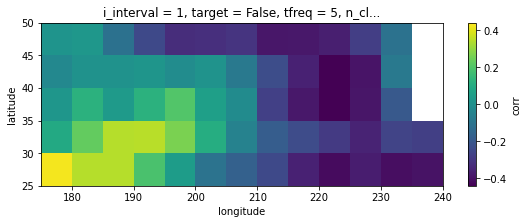

In [5]:
field_resampled.corr.sel(i_interval=1).plot(cmap='viridis', size=3, aspect=3)

Next we can cluster the remaining grid points with `DBSCAN`.

Compare these results with the [prototype-notebook](https://github.com/AI4S2S/s2spy/blob/6da3233168bc7b083b084a14f7afe5618b8c82c9/notebooks/prototype_RGDR.ipynb).

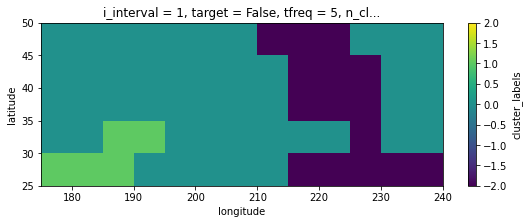

In [6]:
import s2spy.rgdr

clusters = s2spy.rgdr._rgdr.masked_spherical_dbscan(
    field_resampled.sel(i_interval=1),
    eps_km=600,
    alpha=0.05,
    min_area_km2=3000**2
)

clusters.cluster_labels.plot(cmap='viridis', size=3, aspect=3)


The above plot showing clusters will probably be useful for users to understand what is going on,
and will be required to finetune the parameters `eps_km` and `min_area_km2`. 

(Note: negative labels denote clusters with a negative correlation, positive labels clusters
with a positive correlation, and `0` labelled data is not within a cluster.)

`_rgdr.reduce_to_clusters` will both perform the clustering and return means per cluster:

(and thus not providing direct feedback on what geographical region the clusters represent)

In [7]:
clustered_data = s2spy.rgdr._rgdr.reduce_to_clusters(
    field_resampled.sel(i_interval=1),
    eps_km=600, 
    alpha=0.04
)
clustered_data

<xarray.Dataset>
Dimensions:         (anchor_year: 39, cluster_labels: 3)
Coordinates:
    index           (anchor_year) int64 1 13 25 37 49 61 ... 409 421 433 445 457
    interval        (anchor_year) object (1980-07-02, 1980-08-01] ... (2018-0...
  * anchor_year     (anchor_year) int64 1980 1981 1982 1983 ... 2016 2017 2018
    i_interval      int64 1
    target          bool False
    tfreq           int64 5
    n_clusters      int64 6
    cluster         int64 3
  * cluster_labels  (cluster_labels) float64 -1.0 0.0 1.0
Data variables:
    sst             (cluster_labels, anchor_year) float64 290.8 291.0 ... 298.2
    corr            (cluster_labels) float64 -0.3901 -0.06555 0.3602
    p_val           (cluster_labels) float64 0.01541 0.4659 0.02706
    area            (cluster_labels) float64 3.961e+06 3.869e+06 4.301e+06

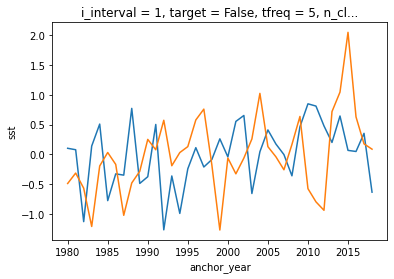

In [8]:
clustered_data['sst'] -= clustered_data['sst'].mean(dim='anchor_year')

clustered_data['sst'].sel(cluster_labels=1).plot.line(x='anchor_year')
clustered_data['sst'].sel(cluster_labels=-1).plot.line(x='anchor_year')


Selecting different intervals for the precursor data (i.e. lags) will have a significant impact on the clusters that will be found:

In [9]:
n_intervals = field_resampled.i_interval.size
cdata = [0]*n_intervals
for interval in range(n_intervals):
    cdata[interval] = s2spy.rgdr._rgdr.reduce_to_clusters(
        field_resampled.sel(i_interval=interval), eps_km=600, alpha=0.05)

[c.cluster_labels.values for c in cdata]

[array([-1.,  0.]),
 array([-2., -1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-2., -1.,  0.]),
 array([-2., -1.,  0.]),
 array([-3., -2., -1.,  0.]),
 array([-1.,  0.]),
 array([-1.,  0.]),
 array([-1.,  0.]),
 array([0.]),
 array([-1.,  0.])]